#  <font color=green>Credit Card Fraud Detection Project</font>

## Imports 

In [1]:
import numpy as np 
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn





## Data Importing

In [2]:



data = pd.read_csv('../input/creditcard.csv')

## Exploring the Dataset

In [3]:
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [4]:
data.shape

(284807, 31)

In [5]:
# random_state helps assure that you always get the same output when you split the data
# this helps create reproducible results and it does not actually matter what the number is
# frac is percentage of the data that will be returned
data = data.sample(frac = 0.2, random_state = 1)
print(data.shape)



(56961, 31)


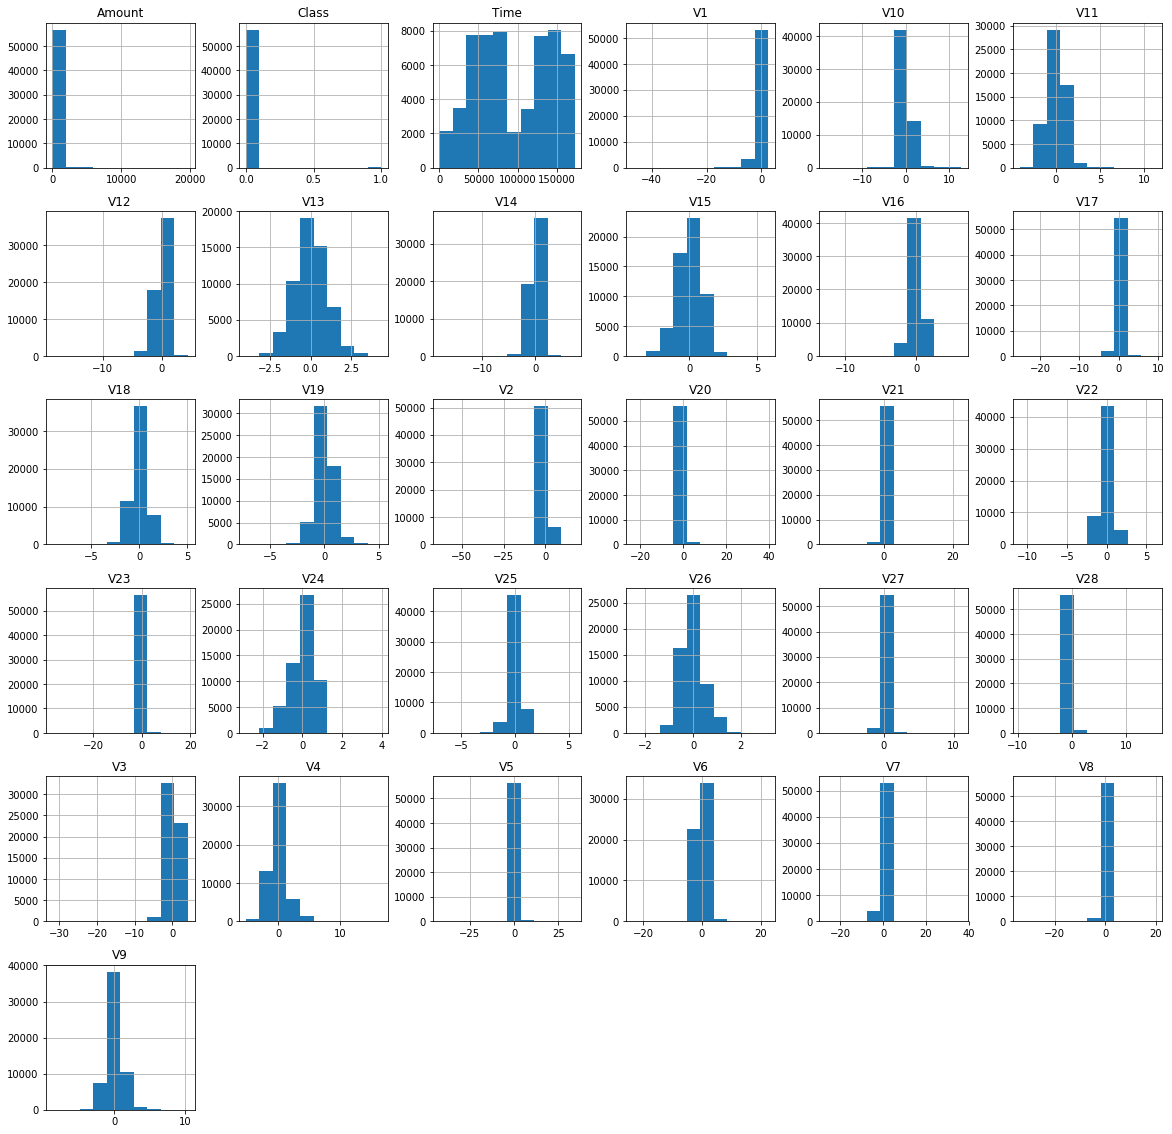

In [6]:
# plot the histogram of each parameter
data.hist(figsize = (20,20))
plt.show()


You can see most of the V's are clustered around 0 with some or no outliers. Notice we have very few fraudulent cases over valid cases in our class histogram.

In [7]:
# determine the number of fraud cases
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]

outlier_fraction = len(fraud)/float(len(valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(fraud)))
print('Valid Cases: {}'.format(len(valid)))



0.0015296972254457222
Fraud Cases: 87
Valid Cases: 56874


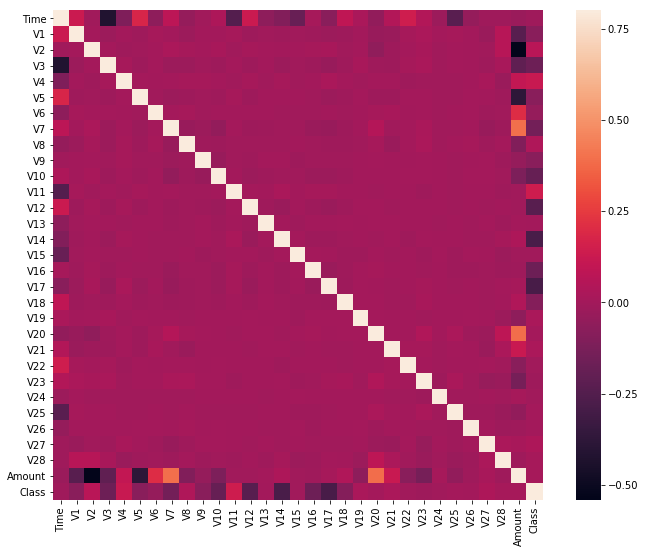

In [8]:
# correlation matrix

corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = 0.8, square = True)
plt.show()



You can see a lot of the values are close to 0 . Most of them are fairly unrelated. The lighter squares signify a stronger correlation. 

## Organizing the Data

In [9]:
columns = data.columns.tolist()

columns = [c for c in columns if c not in ['Class']]

target = 'Class'

X = data[columns]
Y = data[target]

print(X.shape)
print(Y.shape)




(56961, 30)
(56961,)


## Applying Algorithms

In [10]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor



In [11]:
state = 1

classifiers = {
    'Isolation Forest': IsolationForest(max_samples = len(X), 
                                        contamination = outlier_fraction, 
                                        random_state = state), 
    'Local Outlier Factor': LocalOutlierFactor(
    n_neighbors = 20, 
    contamination = outlier_fraction)
}



## Fit the Model

In [12]:
n_outliers = len(fraud)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    if clf_name == 'Local Outlier Factor':
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
        
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    print('{}:{}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))



/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest:129
0.9977352925685996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.26      0.26      0.26        87

   micro avg       1.00      1.00      1.00     56961
   macro avg       0.63      0.63      0.63     56961
weighted avg       1.00      1.00      1.00     56961

Local Outlier Factor:173
0.9969628342199048
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.01      0.01      0.01        87

   micro avg       1.00      1.00      1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961



Looking at precision for fraudulent cases (1) lets us know the percentage of cases that are getting correctly labeled. 'Precision' accounts for false-positives. 'Recall' accounts for false-negatives. Low numbers could mean that we are constantly calling clients asking them if they actually made the transaction which could be annoying.

Goal: To get better percentages.

Our Isolation Forest method (which is Random Forest based) was able to produce a better result. Looking at the f1-score 26% (or approx. 30%) of the time we are going to detect the fraudulent transactions.